# TensorFlow 2.0 Question Answering
## Identify the answers to real user questions about Wikipedia page content


## SHORT Q&A MODEL

In [ ]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go

import plotly.express as px
import pandas as pd
pd.set_option('max_columns', 1000)
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
#import lightgbm as lgb
import plotly.figure_factory as ff
import gc

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import json
from tensorflow.keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from keras.layers import Reshape,Concatenate 
from tensorflow.keras.layers import Reshape
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
#from tensorboardcolab import *
from tensorflow.keras.regularizers import l2  
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Masking
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling2D
from tqdm import tqdm
import pickle
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec 
from tqdm import tqdm
import tensorflow as tf
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [ ]:
import tokenization
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Masking
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tqdm import tqdm_notebook as tqdm
import fasttext
import os
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling2D
import json
import gc
import pickle
from tensorflow.keras.preprocessing import text, sequence 
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import backend
import datetime
from tensorflow.keras.callbacks import TensorBoard 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

## Reading the data

In [ ]:
def read_data(path, sample = True, chunksize = 50000): 
    if sample == True:
        df = [] 
        with open(path, 'rt') as reader:
            for i in range(chunksize):
                df.append(json.loads(reader.readline()))
        df = pd.DataFrame(df)
        print('Our sampled dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True)
        print('Our dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df

train1 = read_data('simplified-nq-train.jsonl', sample = True)
#test = read_data('simplified-nq-test.jsonl', sample = False)
train1.head()

## Empty Short indices

In [ ]:
empty_shortindices=[]

for i in range(50000):
    if not train1['annotations'][i][0]['short_answers']:
        empty_shortindices.append(i)


## Yes Answers

In [ ]:
yl=[]
for i in range(50000):
    if train1['annotations'][i][0]['yes_no_answer']=='YES':
        yl.append(i)
print(len(yl))

## No Answers

In [ ]:
nl=[]
for i in range(50000):
    if train1['annotations'][i][0]['yes_no_answer']=='NO':
        nl.append(i)
print(len(nl))

## Combining yes and no

In [ ]:
ynl=yl+nl


## Extracting data points excluding empty indices

In [ ]:
nonemptyshortindlist=[]
for i in range(50000):
    if i not in empty_shortindices: 
        nonemptyshortindlist.append(i)
print(len(nonemptyshortindlist))

## Final indices (comibnation of yes_no and non_empty indices)

In [ ]:
finalshort=nonemptyshortindlist+ynl

## Replacing the yes_no indices with 0

In [ ]:
for i in ynl:
    train1['annotations'][i][0]['short_answers'].append({'start_token': 0, 'end_token': 0})

## Adding to the dataframe

In [ ]:
df=pd.DataFrame()

In [ ]:
ann_id=[]
ques=[]
doc_text=[]
yn_label=[]
eid=[]

for i in finalshort:
    
    id1=train1['annotations'][i][0]['annotation_id']
    q=train1['question_text'][i]
    dt=train1['document_text'][i]
    ynl=train1['annotations'][i][0]['yes_no_answer']   
    ei=train1['example_id'][i]
    
    ann_id.append(id1)
    ques.append(q)
    doc_text.append(dt)
    yn_label.append(ynl)
    eid.append(ei)


In [ ]:
s_i=[]
for i in finalshort:
    si=train1['annotations'][i][0]['short_answers'][0]['start_token']
    s_i.append(si)

In [ ]:
e_i=[]
for i in finalshort:
    ei=train1['annotations'][i][0]['short_answers'][0]['end_token']
    e_i.append(ei)

In [ ]:
df['annotation_id']=ann_id
df['document_text']=doc_text
df['question_text']=ques
df['yes_or_no']=yn_label
df['start_index']=s_i
df['end_index']=e_i
df['example_id']=eid

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df[['document_text','question_text','example_id']],df[['yes_or_no','start_index','end_index']],test_size=0.2)

## Load train and test data

In [ ]:
X_train = pickle.load(open("X_trainf1.pickel","rb"))
X_test = pickle.load(open("X_testf1.pickel","rb"))
y_train = pickle.load(open("y_trainf1.pickel","rb"))
y_test = pickle.load(open("y_testf1.pickel","rb"))


## Creating BERT Embeddings

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 200

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids") 

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False) 
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
import tokenization

In [ ]:
tokenizer= tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
pickle.dump(tokenizer, open("tokenizerf.pickel", "wb"))
tokenizer = pickle.load(open("tokenizerf.pickel","rb"))

In [ ]:
tokenizer = pickle.load(open("tokenizerf.pickel","rb"))

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try: 
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)  
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

In [ ]:
max_seq_length=200

In [ ]:
def TokenizeAndConvertToIds(text):
    tokens= tokenizer.tokenize(text) # tokenize the reviews
    tokens=tokens[0:(max_seq_length-2)] 
    tokens=['[CLS]',*tokens,'[SEP]'] # adding cls and sep at the end
    masked_array=np.array([1]*len(tokens) + [0]* (max_seq_length-len(tokens))) # masking 
    segment_array=np.array([0]*max_seq_length) 
    if(len(tokens)<max_seq_length): 
        padding=['[PAD]']*(max_seq_length-len(tokens)) # padding
        tokens=[*tokens,*padding] 
    tokentoid=np.array(tokenizer.convert_tokens_to_ids(tokens)) # converting the tokens to id
    return tokentoid,masked_array,segment_array


In [ ]:
X_tr=X_train['document_text']
X_te=X_test['document_text']

In [ ]:
X_trq=X_train['question_text']
X_teq=X_test['question_text']

In [ ]:
pickle.dump(X_tr, open("X_trf.pickel", "wb"))
pickle.dump(X_te, open("X_tef.pickel", "wb"))

In [ ]:
pickle.dump(X_trq, open("X_trqf.pickel", "wb"))
pickle.dump(X_teq, open("X_teqf.pickel", "wb"))

In [ ]:
X_tr = pickle.load(open("X_trf.pickel","rb"))
X_te = pickle.load(open("X_tef.pickel","rb"))

In [ ]:
X_trq = pickle.load(open("X_trqf.pickel","rb"))
X_teq = pickle.load(open("X_teqf.pickel","rb"))

In [ ]:
%%time
from tqdm import tqdm
X_train_tokens,X_test_tokens=[],[]
X_train_mask,X_test_mask=[],[] 
X_train_segment,X_test_segment=[],[]
for i in tqdm(X_tr):
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i) 
    X_train_tokens.append(tokentoid) 
    X_train_mask.append(masked_array)
    X_train_segment.append(segment_array) 
for i in tqdm(X_te): 
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i)
    X_test_tokens.append(tokentoid)
    X_test_mask.append(masked_array)
    X_test_segment.append(segment_array)


In [ ]:
X_train_tokens,X_test_tokens=np.asarray(X_train_tokens),np.asarray(X_test_tokens)
X_train_mask,X_test_mask=np.asarray(X_train_mask),np.asarray(X_test_mask) 
X_train_segment,X_test_segment=np.asarray(X_train_segment),np.asarray(X_test_segment) 

In [ ]:
def grader_alltokens_train(): 
    out = False 
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length) 
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]   
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment) 
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output 
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
pickle.dump(X_train_pooled_output,open('X_train_pooled_output.pkl','wb'))

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output 
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])  

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump(X_test_pooled_output,open('X_test_pooled_output.pkl','wb'))

In [ ]:
X_train_pooled_output = pickle.load(open("X_train_pooled_output.pkl","rb"))
X_test_pooled_output = pickle.load(open("X_test_pooled_output.pkl","rb"))

In [ ]:
from tqdm import tqdm
X_train_tokens,X_test_tokens=[],[]
X_train_mask,X_test_mask=[],[]
X_train_segment,X_test_segment=[],[]
for i in tqdm(X_trq):
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i) 
    X_train_tokens.append(tokentoid) 
    X_train_mask.append(masked_array)
    X_train_segment.append(segment_array) 
for i in tqdm(X_teq): 
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i)
    X_test_tokens.append(tokentoid)
    X_test_mask.append(masked_array)
    X_test_segment.append(segment_array)

In [ ]:
X_train_tokens,X_test_tokens=np.asarray(X_train_tokens),np.asarray(X_test_tokens)
X_train_mask,X_test_mask=np.asarray(X_train_mask),np.asarray(X_test_mask) 
X_train_segment,X_test_segment=np.asarray(X_train_segment),np.asarray(X_test_segment) 

In [ ]:
def grader_alltokens_train(): 
    out = False 
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length) 
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]   
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment) 
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output 
X_train_pooled_outputq=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output 
X_test_pooled_outputq=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])  

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump(X_train_pooled_outputq,open('X_train_pooled_outputq.pkl','wb'))
pickle.dump(X_test_pooled_outputq,open('X_test_pooled_outputq.pkl','wb'))

In [ ]:
X_train_pooled_outputq = pickle.load(open("X_train_pooled_outputq.pkl","rb"))
X_test_pooled_outputq = pickle.load(open("X_test_pooled_outputq.pkl","rb"))

## Reshaping the data

In [ ]:
X_traint=X_train_pooled_output.reshape(X_train_pooled_output.shape[0],X_train_pooled_output.shape[1],1) 

In [ ]:
X_trainq=X_train_pooled_outputq.reshape(X_train_pooled_outputq.shape[0],X_train_pooled_outputq.shape[1],1) 

In [ ]:
print(X_traint.shape)
print(X_trainq.shape)

(14574, 768, 1)
(14574, 768, 1)


## Model 

In [ ]:
k = tf.keras.initializers.he_uniform(seed=None)

## Model 2

In [ ]:
tokenizer = Tokenizer(lower=False, num_words=80000)

for text in tqdm(X_train.question_text.values):
    tokenizer.fit_on_texts(text.split(" "))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
pickle.dump(tokenizer, open("tokenizershort.pickel", "wb"))


In [ ]:
tokenizer = pickle.load(open("tokenizershort.pickel","rb"))

In [ ]:
def compute_text_and_questions(X_train,tokenizer):
    
    #train_text = tokenizer.texts_to_sequences(X_train.text.values)
    train_questions = tokenizer.texts_to_sequences(X_train.question_text.values)  
    #train_text = sequence.pad_sequences(train_text, maxlen=300)
    train_questions = sequence.pad_sequences(train_questions)

    return train_questions


In [ ]:
def compute_text_and_questions1(X_test,tokenizer):
    
    test_questions = tokenizer.texts_to_sequences(X_test.question_text.values)
    
    
    #train_text = sequence.pad_sequences(train_text, maxlen=300)
    test_questions = sequence.pad_sequences(test_questions)

   # return train_text, train_questions,cv_text,cv_questions, test_text, test_questions
    return test_questions


In [ ]:
train_questions=compute_text_and_questions(X_train,tokenizer)
test_questions=compute_text_and_questions1(X_test,tokenizer)

## Embedding Matrix creation

In [ ]:
def build_embedding_matrix(tokenizer, path):
    embedding_matrix = np.zeros((tokenizer.num_words + 1, 300))
    ft_model = fasttext.load_model(path)

    for word, i in tokenizer.word_index.items():
        if i >= tokenizer.num_words - 1:
            break
        embedding_matrix[i] = ft_model.get_word_vector(word)
    
    return embedding_matrix

In [ ]:
path = 'crawl-300d-2M-subword.bin'
embedding_matrix = build_embedding_matrix(tokenizer, path)

In [ ]:
embedding_matrix.shape

(80001, 300)

In [ ]:
embedding = Embedding(
        *embedding_matrix.shape, 
        weights=[embedding_matrix], 
        trainable=False, 
        mask_zero=True)

## Getting train Reshape

In [ ]:
X_traint=X_train_pooled_output.reshape(X_train_pooled_output.shape[0],X_train_pooled_output.shape[1],1) 

In [ ]:
k = tf.keras.initializers.he_uniform(seed=None)

## Model 2

In [ ]:
q_in = Input(shape=(None,),name='input1')
q= embedding(q_in)
q= layers.Bidirectional(tf.keras.layers.LSTM(32, activation="tanh",recurrent_activation="sigmoid",
                                         return_sequences=True))(q)
q=tf.keras.layers.LeakyReLU(alpha=0.3)(q) 
q= tensorflow.keras.layers.GlobalMaxPooling1D()(q)

#q = embedding(q_in)
#q = SpatialDropout1D(0.2)(q)
#q = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(q)
#q = tensorflow.keras.layers.GlobalMaxPooling1D()(q)

t_in = Input(shape=X_traint.shape[1:],name='input2')  
t=Conv1D(32, kernel_size=(3), activation='relu',strides=1,name='text_conv1d')(t_in) 
t=Conv1D(64, kernel_size=(3), activation='relu', strides=1)(t) 
t=tf.keras.layers.LeakyReLU(alpha=0.3)(t)
t= tensorflow.keras.layers.GlobalMaxPooling1D()(t)

concat1 = concatenate([q, t])
hidden = Dense(700, activation='relu',kernel_initializer=k)(concat1)
hidden=tf.keras.layers.LeakyReLU(alpha=0.3)(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(600, activation='relu',kernel_initializer=k)(hidden)
hidden=tf.keras.layers.LeakyReLU(alpha=0.3)(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(500, activation='relu',kernel_initializer=k)(hidden)
#hidden=tf.keras.layers.LayerNormalization()(hidden)

    
out1 = Dense(1, activation='softplus',name='out1')(hidden)
out2 = Dense(1, activation='softplus',name='out2')(hidden)
out=Dense(3,activation='softmax',name='out')(hidden)

model = Model(inputs=[q_in, t_in], outputs=[out1,out2,out])
model.compile(loss={'out1':'mean_squared_logarithmic_error','out2':'mean_squared_logarithmic_error',
                   'out':'categorical_crossentropy'} , optimizer=tf.keras.optimizers.Adam(learning_rate=0.03))

In [ ]:
print(model.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 768, 1)]     0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    24000300    input1[0][0]                     
__________________________________________________________________________________________________
text_conv1d (Conv1D)            (None, 766, 32)      128         input2[0][0]                     
_______________________________________________________________________________________

## Image 1

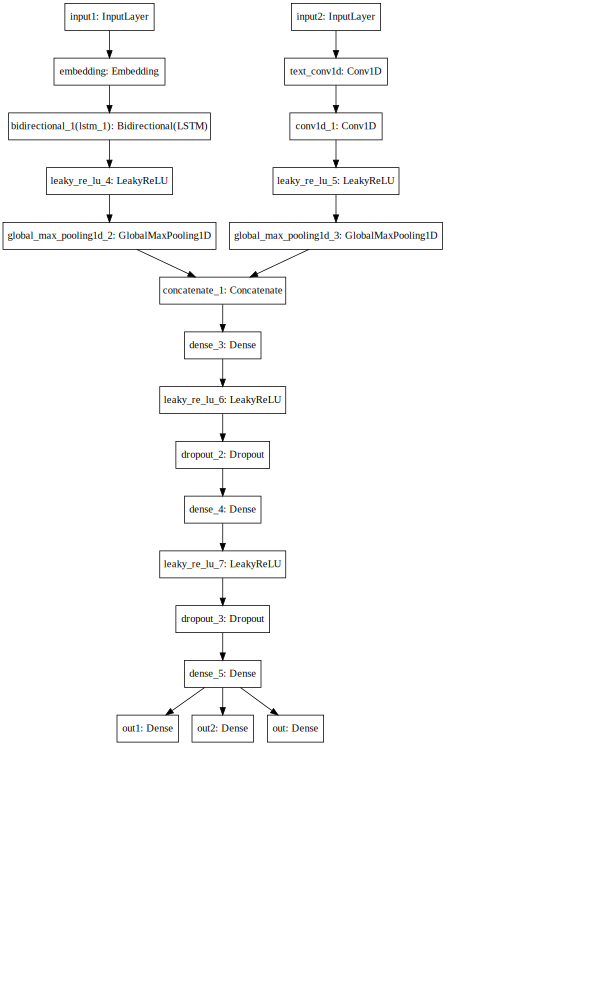

In [ ]:
SVG(model_to_dot(model).create(prog='dot',format='svg'))

## Image 2

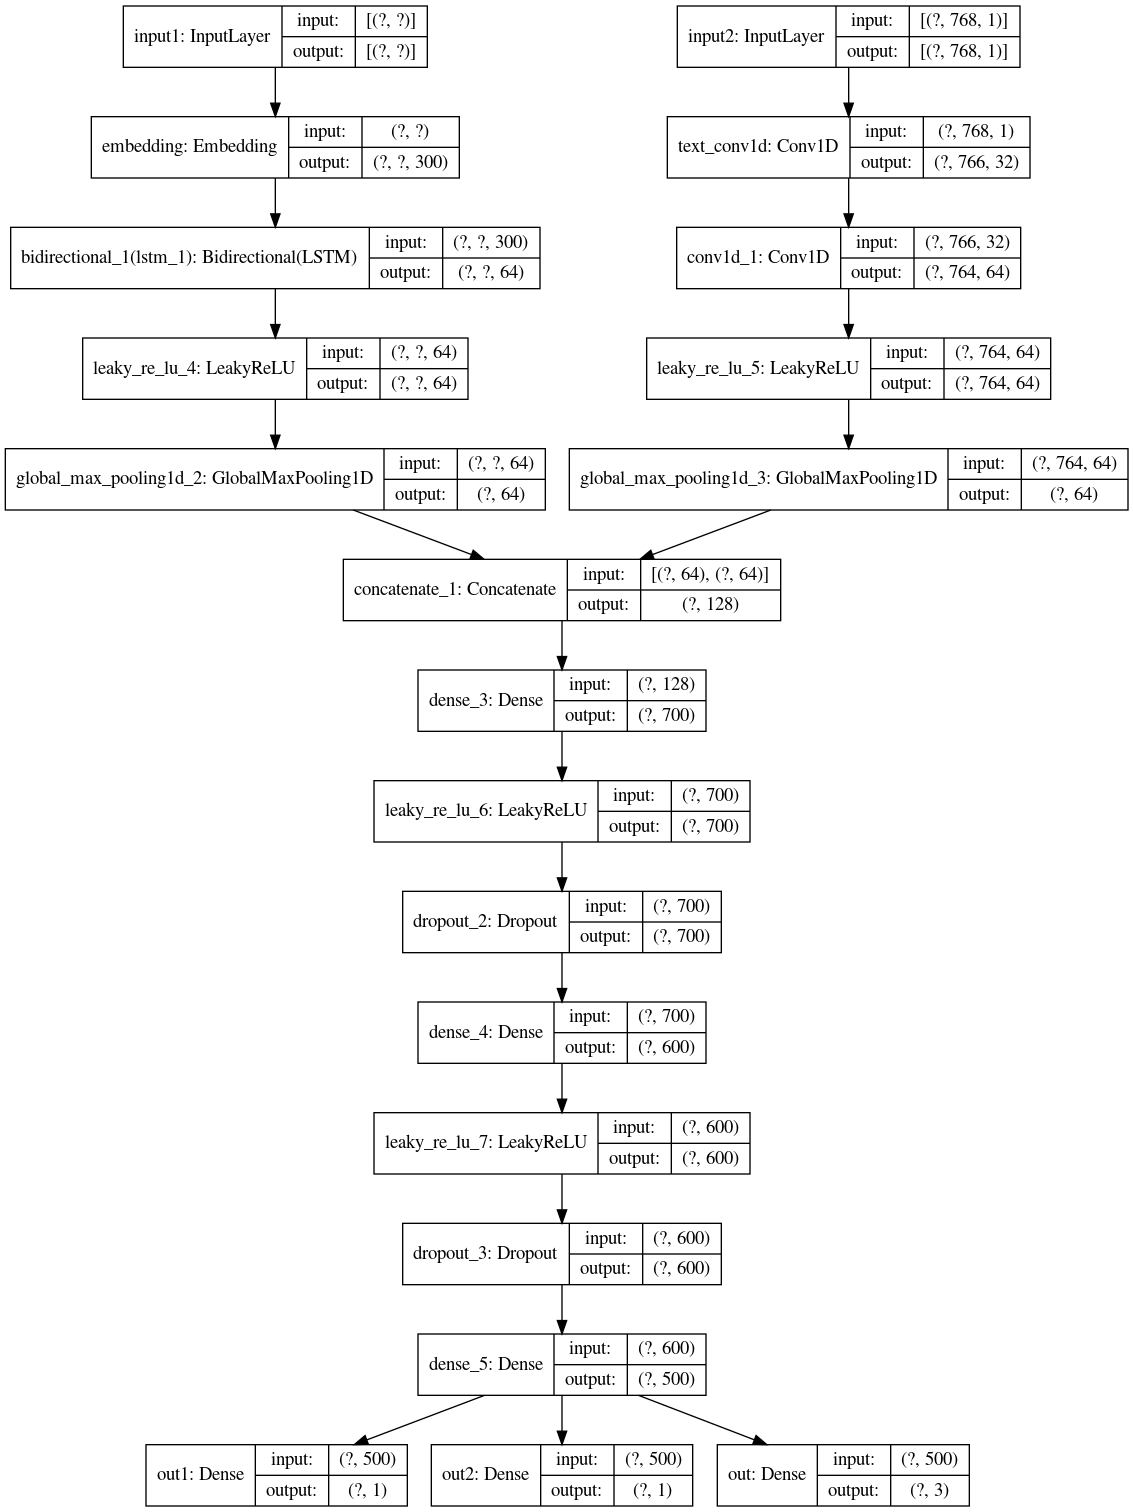

In [ ]:
tf.keras.utils.plot_model(model,to_file="modellong.png",show_shapes=True)

## Start and End indices

In [ ]:
y_trainsi=np.array(y_train['start_index'].apply('int32'))
#y_cvsi=np.array(y_cv['start_index'])
y_testsi=np.array(y_test['start_index'].apply('int32'))

y_trainei=np.array(y_train['end_index'].apply('int32'))
#y_cvei=np.array(y_cv['end_index'])
y_testei=np.array(y_test['end_index'].apply('int32'))

In [ ]:
filepath="shortmodel2.cp5"
checkpoint_1 = ModelCheckpoint(filepath,monitor="val_auroc",mode="max",save_best_only = True,verbose=1)

In [ ]:
logdir = os.path.join("logssf2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
callbacks_3 = [tensorboard_callback,checkpoint_1]

In [ ]:
from tensorflow.keras.optimizers import SGD
from swa.tfkeras import SWA

## YES_NO_NONE LABELS

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(y_train['yes_or_no']) 

y_train1=vectorizer.transform(y_train['yes_or_no'].values) 
#y_cv1 = vectorizer.transform(y_cv['yes_or_no'].values) 
y_test1 = vectorizer.transform(y_test['yes_or_no'].values) 

In [ ]:
y_train1=y_train1.toarray() 
#y_cv1=y_cv1.toarray()
y_test1=y_test1.toarray()

## Training

In [ ]:
tf.profiler.experimental.stop

<function tensorflow.python.profiler.profiler_v2.stop(save=True)>

In [ ]:
train_history1 = model.fit({'input1':train_questions,'input2':X_traint}, 
                           {'out1':y_trainsi,'out2':y_trainei,'out':y_train1},
    epochs=30,batch_size=620,validation_split=0.3,callbacks=callbacks_3)

Epoch 1/30
 1/17 [>.............................] - ETA: 0s - loss: 3.3464 - out1_loss: 1.6783 - out2_loss: 1.6324 - out_loss: 0.0357WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
17/17 [==============================] - 9s 521ms/step - loss: 3.4106 - out1_loss: 1.6716 - out2_loss: 1.6246 - out_loss: 0.1144 - val_loss: 4.4680 - val_out1_loss: 1.8561 - val_out2_loss: 1.8100 - val_out_loss: 0.8019
Epoch 2/30
17/17 [==============================] - 8s 490ms/step - loss: 3.4008 - out1_loss: 1.6726 - out2_loss: 1.6253 - out_loss: 0.1029 - val_loss: 4.3797 - val_out1_loss: 1.8459 - val_out2_loss: 1.7999 - val_out_loss: 0.7340
Epoch 3/30
17/17 [==============================] - 8s 489ms/step - loss: 3.3860 - out1_loss: 1.6581 - out2_loss: 1.6119 - out_loss: 0.1160 

In [ ]:
model.save('shortmodelfinal')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: shortmodelfinal/assets


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logssf2 --port=6006 --bind_all

## Epoch vs Validation of Start Index

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Val_out1_loss") 
    ax.plot(x, ty, 'r', label="Train Loss")                                       
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    

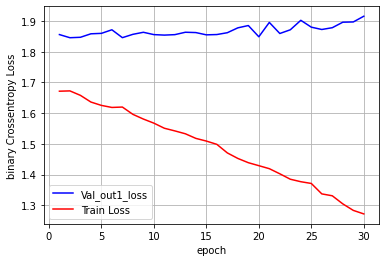

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,30+1))

vy = train_history1.history['val_out1_loss']
ty = train_history1.history['out1_loss']
plt_dynamic(x, vy, ty, ax)

## Epoch vs Validation of End Index

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Val_out2_loss") 
    ax.plot(x, ty, 'r', label="out2_loss")                                       
    plt.legend()
    plt.grid()
    fig.canvas.draw()

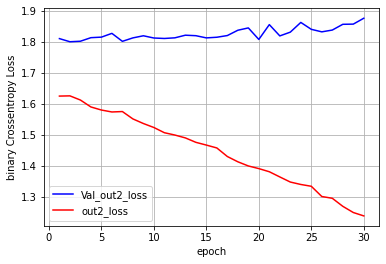

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,30+1))

vy = train_history1.history['val_out2_loss']
ty = train_history1.history['out2_loss']
plt_dynamic(x, vy, ty, ax)

## Epoch vs Validation of YES_OR_NO DATA

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Val_out_loss") 
    ax.plot(x, ty, 'r', label="out_loss")                                       
    plt.legend()
    plt.grid()
    fig.canvas.draw()

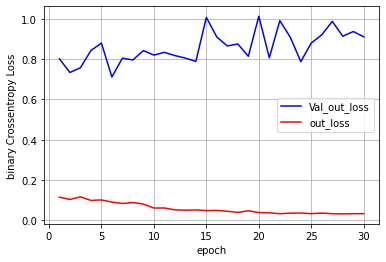

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,30+1))

vy = train_history1.history['val_out_loss']
ty = train_history1.history['out_loss']
plt_dynamic(x, vy, ty, ax)

## Predicting the Train Data

In [ ]:
predtrain1=model.predict([train_questions,X_traint])

In [ ]:
trsite=[]
for i in y_train['start_index']:
    trsite.append(i)

In [ ]:
treite=[]
for i in y_train['end_index']:
    treite.append(i)

In [ ]:
#true start indices
trst=[]
for i in range(len(trsite)):
    c=int(trsite[i])
    trst.append(c)

In [ ]:
#true end indices
tren=[]
for i in range(len(treite)):
    c=int(treite[i])
    tren.append(c)

In [ ]:
#pred start indices
prst=[]
for i in range(len(predtrain1[0])):
    c=int(predtrain1[0][i][0])
    prst.append(c) 
#pred end indices
pren=[]
for i in range(len(predtrain1[0])):
    c=int(predtrain1[1][i][0])
    pren.append(c)

In [ ]:
pr=[]
tr=[]
for i in range(0,len(trst)): #data points count
    tr.append(X_train['document_text'].values[i].split(" ")[trst[i]:tren[i]]) #true start and end indices
    pr.append(X_train['document_text'].values[i].split(" ")[prst[i]:pren[i]])# pred start and end indices

In [ ]:
def Avg(lst): 
    return sum(lst) / len(lst) 

## Jaccardian Similarity of Train Data

In [ ]:
def jaccard_similarity(tr,pr): #true values and pred values 
#intersection
    jk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i]) 
        c= len(set(a).intersection(b))
        jk.append(c) 
#union
    vk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i])
        v= len(list(a.union(b)))
        vk.append(v)
        
#intersection/union        
    f=[]
    for i in range(len(jk)):
        jac=jk[i]/(vk[i]+0.1)
        f.append(jac)
        
    return Avg(f)
    
    
print("The Jaccard Similarity for long answer model is:",jaccard_similarity(tr,pr))

The Jaccard Similarity for long answer model is: 0.016739399852015578


## Micro F1 Score of only yes_no label data points of Train Data

In [ ]:
indf=[]
for i in range(len(predtrain1[0])): 
    arg_max=np.argmax(predtrain1[2][i])
    indf.append(arg_max) 

In [ ]:
yesnolist=[]
for i in range(len(indf)):
    if indf[i]==0:
        yesnolist.append('NO')
    elif indf[i]==1:
        yesnolist.append('NONE')
    elif indf[i]==2:
        yesnolist.append('YES')

In [ ]:
trueyn=[]
for i in y_train['yes_or_no']:
    trueyn.append(i)

In [ ]:
len(trueyn)

14574

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
h2=[]
h3=[]
for i in range(0,len(yesnolist)):
    if y_train['yes_or_no'].values[i]=='NO'or y_train['yes_or_no'].values[i]=='YES':
        h2.append(y_train['yes_or_no'].values[i])
        h3.append(i)

In [ ]:
h1=[]
for i in h3: 
    if yesnolist[i]=='NO'or yesnolist[i]=='YES':
        h1.append(yesnolist[i])
    else:
        h1.append('')

In [ ]:
len(h2)

506

## Micro F1 Score of Train data

In [ ]:
f1_score(h1,h2,average='micro')

0.5849802371541502

## True and Predicted Yes_No values of Train data

In [ ]:
for i in zip(h2,h1):
    print(i)

('YES', 'YES')
('NO', 'YES')
('NO', 'YES')
('NO', 'YES')
('NO', 'YES')
('NO', 'YES')
('NO', 'NO')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', 'YES')
('NO', '')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('NO', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('NO', 'YES')
('YES', 'NO')
('YES', 'NO')
('YES', 'YES')
('YES', 'YES')
('YES', '')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('NO', 'YES')
('NO', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'NO')
('YES', 'YES')
('NO', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', 'YES')
('NO', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YE

## Predicting with the test data

In [ ]:
X_testq=X_test_pooled_outputq.reshape(X_test_pooled_outputq.shape[0],X_test_pooled_outputq.shape[1],1) 

In [ ]:
X_testt=X_test_pooled_output.reshape(X_test_pooled_output.shape[0],X_test_pooled_output.shape[1],1) 

In [ ]:
predf1=model.predict([test_questions,X_testt])    

In [ ]:
predf1[0]

array([[488.36972],
       [701.93604],
       [640.74567],
       ...,
       [447.14496],
       [283.6455 ],
       [722.128  ]], dtype=float32)

In [ ]:
predf1[1]

array([[498.159  ],
       [715.8833 ],
       [653.4905 ],
       ...,
       [456.1221 ],
       [289.44458],
       [736.4523 ]], dtype=float32)

In [ ]:
trsite=[]
for i in y_test['start_index']:
    trsite.append(i)
treite=[]
for i in y_test['end_index']:
    treite.append(i)
#true start indices
trst=[]
for i in range(len(trsite)):
    c=int(trsite[i])
    trst.append(c)
#true end indices
tren=[]
for i in range(len(treite)):
    c=int(treite[i])
    tren.append(c)

In [ ]:
#pred start indices
prst=[]
for i in range(len(predf1[0])):
    c=int(predf1[0][i][0])
    prst.append(c) 
#pred end indices
pren=[]
for i in range(len(predf1[0])):
    c=int(predf1[1][i][0])
    pren.append(c)

In [ ]:
pr=[]
tr=[]
for i in range(0,len(trst)): #data points count
    tr.append(X_test['document_text'].values[i].split(" ")[trst[i]:tren[i]]) #true start and end indices
    pr.append(X_test['document_text'].values[i].split(" ")[prst[i]:pren[i]])# pred start and end indices

In [ ]:
def Avg(lst): 
    return sum(lst) / len(lst) 

In [ ]:
def jaccard_similarity(tr,pr): #true values and pred values 
#intersection
    jk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i]) 
        c= len(set(a).intersection(b))
        jk.append(c) 
#union
    vk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i])
        v= len(list(a.union(b)))
        vk.append(v)
        
#intersection/union        
    f=[]
    for i in range(len(jk)):
        jac=jk[i]/(vk[i]+0.1)
        f.append(jac)
        
    return Avg(f)
    
    
print("The Jaccard Similarity for long answer model is:",jaccard_similarity(tr,pr))

The Jaccard Similarity for long answer model is: 0.016501299399126465


## Micro F1 Score of only yes_no label data points of Test Data

In [ ]:
indf=[]
for i in range(len(predf1[0])): 
    arg_max=np.argmax(predf1[2][i])
    indf.append(arg_max) 

In [ ]:
yesnolist=[]
for i in range(len(indf)):
    if indf[i]==0:
        yesnolist.append('NO')
    elif indf[i]==1:
        yesnolist.append('NONE')
    elif indf[i]==2:
        yesnolist.append('YES')
        

In [ ]:
trueyn=[]
for i in y_test['yes_or_no']:
    trueyn.append(i)

In [ ]:
len(yesnolist)

3644

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
h2=[]
h3=[]
for i in range(0,3644):
    if y_test['yes_or_no'].values[i]=='NO'or y_test['yes_or_no'].values[i]=='YES':
        h2.append(y_test['yes_or_no'].values[i])
        h3.append(i)

In [ ]:
h1=[]
for i in h3: 
    if yesnolist[i]=='NO'or yesnolist[i]=='YES':
        h1.append(yesnolist[i])
    else:
        h1.append('')

## Micro F1 Score of Test data

In [ ]:
f1_score(h1,h2,average='micro')

0.47368421052631576

## True and Predicted Yes_No values of Test Data

In [ ]:
for i in zip(h2,h1):
    print(i)

('YES', 'YES')
('NO', '')
('YES', 'YES')
('YES', 'YES')
('YES', '')
('NO', '')
('NO', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', 'YES')
('NO', 'YES')
('YES', '')
('YES', '')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', '')
('YES', '')
('NO', '')
('YES', '')
('NO', '')
('NO', 'NO')
('NO', 'YES')
('YES', '')
('NO', 'YES')
('YES', '')
('YES', '')
('YES', '')
('NO', '')
('YES', '')
('YES', 'YES')
('NO', '')
('NO', '')
('NO', 'YES')
('YES', 'YES')
('YES', 'YES')
('YES', '')
('NO', 'YES')
('NO', 'YES')
('YES', 'YES')
('NO', '')
('YES', 'YES')
('YES', 'YES')
('YES', '')
('YES', 'YES')
('NO', '')
('YES', '')
('YES', 'YES')
('NO', '')
('YES', '')
('YES', 'YES')
('NO', 'NO')
('NO', 'YES')
('YES', '')
('YES', 'YES')
('NO', '')
('YES', 'YES')
('NO', '')
('NO', 'YES')
('NO', 'YES')
('NO', '')
('YES', '')
('YES', 'YES')
('YES', 'YES')
('NO', '')
('YES', 'YES')
('NO', '')
('YES', '')
('NO', '')
('NO', 'YES')
('YES', '')
('YES', 'YES')
('YES', 'YES')

In [ ]:
len(h1)

114

## LONG Q&A MODEL

In [ ]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True) 
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
pd.set_option('max_columns', 1000)
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
#import lightgbm as lgb
import plotly.figure_factory as ff
import gc

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import json
from tensorflow.keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from keras.layers import Reshape,Concatenate 
from tensorflow.keras.layers import Reshape
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
#from tensorboardcolab import *
from tensorflow.keras.regularizers import l2  
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Masking
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling2D
from tqdm import tqdm
import pickle
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec 
from tqdm import tqdm
import tensorflow as tf
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [ ]:
import tokenization
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Masking
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tqdm import tqdm_notebook as tqdm
import fasttext
import os
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling2D
import json
import gc
import pickle
from tensorflow.keras.preprocessing import text, sequence 
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import backend
import datetime
from tensorflow.keras.callbacks import TensorBoard 

## Reading the Data

In [ ]:
def read_data(path, sample = True, chunksize = 50000): 
    if sample == True:
        df = [] 
        with open(path, 'rt') as reader:
            for i in range(chunksize):
                df.append(json.loads(reader.readline()))
        df = pd.DataFrame(df)
        print('Our sampled dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True)
        print('Our dataset have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df

train1 = read_data('simplified-nq-train.jsonl', sample = True)
#test = read_data('simplified-nq-test.jsonl', sample = False)
train1.head()

## Data Preparation

In [ ]:
def build_train(train_path, n_rows=200000, sampling_rate=15):
    with open(train_path) as f:
        processed_rows = []

        for i in tqdm(range(n_rows)):
            line = f.readline() 
            if not line:
                break

            line = json.loads(line)

            text = line['document_text'].split(' ')
            question = line['question_text']
            annotations = line['annotations'][0]
            example_id=line['example_id']

            for i, candidate in enumerate(line['long_answer_candidates']):
                label = i == annotations['long_answer']['candidate_index']

                start = candidate['start_token']
                end = candidate['end_token']

                if label:
                    processed_rows.append({
                        'text': " ".join(text),
                        'is_long_answer': label,
                        'question': question,
                        'annotation_id': annotations['annotation_id'],
                        'start_index':start,
                        'end_index':end,
                        'example_id':example_id
                    })

        train = pd.DataFrame(processed_rows)
        
        return train

In [ ]:
train_path='simplified-nq-train.jsonl'

In [ ]:
train= build_train(train_path) 

In [ ]:
pickle.dump(train, open("longtrainbuild.pickel", "wb"))

In [ ]:
train=pickle.load(open("longtrainbuild.pickel","rb"))

In [ ]:
long=train[train['is_long_answer']==True]
long.shape

In [ ]:
pickle.dump(long, open("longbuild.pickel", "wb"))

## Train_Test_Split

In [ ]:
X_trainl, X_testl, y_trainl, y_testl=train_test_split(long[['text','question','example_id']],long[['start_index','end_index']],test_size=0.2)
#X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.2)

In [ ]:
X_trainl = pickle.load(open("X_trainl.pickel","rb"))
y_trainl= pickle.load(open("y_trainl.pickel","rb"))
X_testl = pickle.load(open("X_testl.pickel","rb"))
y_testl=pickle.load(open("y_testl.pickel","rb"))

In [ ]:
X_trainl.head()

,text,question,example_id
69384,Nobel Prize - Wikipedia <H1> Nobel Prize </H1>...,what do you get with the nobel peace prize,5511169681578460606
56120,É - wikipedia <H1> É </H1> Jump to : navigatio...,how do you get the apostrophe over the e,7180563391193184058
98445,Mines and Geosciences Bureau Region 13 ( Phili...,where can manganese be found in the philippines,2727980537421680961
28948,Kensington Security slot - Wikipedia <H1> Kens...,what is a kensington lock slot on a mac,3989086785524790815
3911,Peaches ( the Presidents of the United States ...,peaches presidents of the united states lyrics...,-2266002850140951599


## Creating BERT Embeddings for Train and Test Question & Answers

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 200

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids") 

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False) 
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
bert_model.save("bertmodel.pickel")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: bertmodel.pickel/assets


INFO:tensorflow:Assets written to: bertmodel.pickel/assets


In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
tokenizer= tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
pickle.dump(tokenizer, open("tokenizerf.pickel", "wb"))
tokenizer = pickle.load(open("tokenizerf.pickel","rb"))

In [ ]:
tokenizer = pickle.load(open("tokenizerf.pickel","rb"))

In [ ]:
to = pickle.load(open("tokenizerf.pickel","rb"))

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try: 
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)  
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
max_seq_length=200

In [ ]:
def TokenizeAndConvertToIds(text):
    tokens= tokenizer.tokenize(text) # tokenize the reviews
    tokens=tokens[0:(max_seq_length-2)] 
    tokens=['[CLS]',*tokens,'[SEP]'] # adding cls and sep at the end
    masked_array=np.array([1]*len(tokens) + [0]* (max_seq_length-len(tokens))) # masking 
    segment_array=np.array([0]*max_seq_length) 
    if(len(tokens)<max_seq_length): 
        padding=['[PAD]']*(max_seq_length-len(tokens)) # padding
        tokens=[*tokens,*padding] 
    tokentoid=np.array(tokenizer.convert_tokens_to_ids(tokens)) # converting the tokens to id
    return tokentoid,masked_array,segment_array


In [ ]:
X_tr1=X_trainl['text']
X_te1=X_testl['text']

In [ ]:
X_trq1=X_trainl['question']
X_teq1=X_testl['question']

In [ ]:
pickle.dump(X_tr1, open("X_trf1.pickel", "wb"))
pickle.dump(X_te1, open("X_tef1.pickel", "wb"))

In [ ]:
pickle.dump(X_trq1, open("X_trqf1.pickel", "wb"))
pickle.dump(X_teq1, open("X_teqf1.pickel", "wb"))

In [ ]:
X_tr1 = pickle.load(open("X_trf1.pickel","rb"))
X_te1 = pickle.load(open("X_tef1.pickel","rb"))

In [ ]:
X_trq1 = pickle.load(open("X_trqf1.pickel","rb"))
X_teq1 = pickle.load(open("X_teqf1.pickel","rb"))

In [ ]:
%%time
from tqdm import tqdm
X_train_tokens,X_test_tokens=[],[]
X_train_mask,X_test_mask=[],[] 
X_train_segment,X_test_segment=[],[]
for i in tqdm(X_tr1):
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i) 
    X_train_tokens.append(tokentoid) 
    X_train_mask.append(masked_array)
    X_train_segment.append(segment_array) 
for i in tqdm(X_te1): 
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i)
    X_test_tokens.append(tokentoid)
    X_test_mask.append(masked_array)
    X_test_segment.append(segment_array)


In [ ]:
X_train_tokens,X_test_tokens=np.asarray(X_train_tokens),np.asarray(X_test_tokens)
X_train_mask,X_test_mask=np.asarray(X_train_mask),np.asarray(X_test_mask) 
X_train_segment,X_test_segment=np.asarray(X_train_segment),np.asarray(X_test_segment) 

In [ ]:
def grader_alltokens_train(): 
    out = False 
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length) 
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]   
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment) 
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output 
X_train_pooled_output1=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
pickle.dump(X_train_pooled_output1,open('X_train_pooled_output1.pkl','wb'))

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output 
X_test_pooled_output1=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])  
##save all your results to disk so that, no need to run all again. 

pickle.dump(X_test_pooled_output1,open('X_test_pooled_output1.pkl','wb'))

In [ ]:
X_train_pooled_output1 = pickle.load(open("X_train_pooled_output1.pkl","rb"))
X_test_pooled_output1 = pickle.load(open("X_test_pooled_output1.pkl","rb"))

In [ ]:
from tqdm import tqdm
X_train_tokens,X_test_tokens=[],[]
X_train_mask,X_test_mask=[],[]
X_train_segment,X_test_segment=[],[]
for i in tqdm(X_trq1):
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i) 
    X_train_tokens.append(tokentoid) 
    X_train_mask.append(masked_array)
    X_train_segment.append(segment_array) 
for i in tqdm(X_teq1): 
    tokentoid,masked_array,segment_array=TokenizeAndConvertToIds(i)
    X_test_tokens.append(tokentoid)
    X_test_mask.append(masked_array)
    X_test_segment.append(segment_array)

In [ ]:
X_train_tokens,X_test_tokens=np.asarray(X_train_tokens),np.asarray(X_test_tokens)
X_train_mask,X_test_mask=np.asarray(X_train_mask),np.asarray(X_test_mask) 
X_train_segment,X_test_segment=np.asarray(X_train_segment),np.asarray(X_test_segment) 

In [ ]:
def grader_alltokens_train(): 
    out = False 
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length) 
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]   
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment) 
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output 
X_train_pooled_outputq1=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump(X_train_pooled_outputq1,open('X_train_pooled_outputq1.pkl','wb'))

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output 
X_test_pooled_outputq1=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])  

In [ ]:
pickle.dump(X_test_pooled_outputq1,open('X_test_pooled_outputq1.pkl','wb'))

In [ ]:
X_train_pooled_outputq1 = pickle.load(open("X_train_pooled_outputq1.pkl","rb"))
X_test_pooled_outputq1 = pickle.load(open("X_test_pooled_outputq1.pkl","rb"))

## Train question and text Reshape

In [ ]:
X_traint1=X_train_pooled_output1.reshape(X_train_pooled_output1.shape[0],X_train_pooled_output1.shape[1],1) 

In [ ]:
X_trainq1=X_train_pooled_outputq1.reshape(X_train_pooled_outputq1.shape[0],X_train_pooled_outputq1.shape[1],1) 

In [ ]:
import tensorflow as tf

In [ ]:
k = tf.keras.initializers.he_uniform(seed=None)

## MODEL 2

In [ ]:
tokenizer=pickle.load(open("tokenizerlong2f.pickel","rb"))

In [ ]:
def compute_text_and_questions(X_trainl,tokenizer):
    
    #train_text = tokenizer.texts_to_sequences(X_train.text.values)
    train_questions = tokenizer.texts_to_sequences(X_trainl.question.values)  
    #train_text = sequence.pad_sequences(train_text, maxlen=300)
    train_questions = sequence.pad_sequences(train_questions)

    return train_questions


In [ ]:
def compute_text_and_questions1(X_testl,tokenizer):
    
    test_questions = tokenizer.texts_to_sequences(X_testl.question.values)
    
    
    #train_text = sequence.pad_sequences(train_text, maxlen=300)
    test_questions = sequence.pad_sequences(test_questions)

   # return train_text, train_questions,cv_text,cv_questions, test_text, test_questions
    return test_questions


In [ ]:
train_questions=compute_text_and_questions(X_trainl,tokenizer)
test_questions=compute_text_and_questions1(X_testl,tokenizer)

In [ ]:
def build_embedding_matrix(tokenizer, path):
    embedding_matrix = np.zeros((tokenizer.num_words + 1, 300))
    ft_model = fasttext.load_model(path)

    for word, i in tokenizer.word_index.items():
        if i >= tokenizer.num_words - 1:
            break
        embedding_matrix[i] = ft_model.get_word_vector(word)
    
    return embedding_matrix

In [ ]:
path = 'crawl-300d-2M-subword.bin'
embedding_matrix = build_embedding_matrix(tokenizer, path)

In [ ]:
embedding_matrix.shape

(80001, 300)

In [ ]:
np.save('embedding_matrix1.npy', embedding_matrix) # save
embedding_matrix = np.load('embedding_matrix1.npy') # load

In [ ]:
embedding = Embedding(
        *embedding_matrix.shape, 
        weights=[embedding_matrix], 
        trainable=False, 
        mask_zero=True)

In [ ]:
#k = tf.keras.initializers.GlorotUniform(seed=None)

In [ ]:
q_in = Input(shape=(None,),name='input1') 

#embedding = Embedding(len(tokenizer.word_index)+1,300,input_length=X_train_pooled_outputq1.shape[1:],trainable=False,mask_zero=True)(q_in)
q= embedding(q_in)
q = layers.Bidirectional(tf.keras.layers.LSTM(64, activation="tanh",recurrent_activation="sigmoid",
                                              return_sequences=True),name='questionLSTM')(q)
q = SpatialDropout1D(0.2,name='questionDropout')(q) 
q = tf.keras.layers.LeakyReLU(alpha=0.3,name='questionLeakyReLU')(q) 
q = tensorflow.keras.layers.GlobalMaxPooling1D(name='questionGBMaxPool')(q)


t_in = Input(shape=X_traint1.shape[1:],name='input2')                 
t = Conv1D(32, kernel_size=(3), activation='relu',strides=1, name='textCNN1')(t_in) 
t = Conv1D(64, kernel_size=(3), activation='relu',strides=1,name='textCNN2')(t) 
t = tf.keras.layers.LeakyReLU(alpha=0.3,name='textLeakyReLU')(t)
t = tensorflow.keras.layers.GlobalMaxPooling1D(name='textGBMaxPool')(t)



hidden = concatenate([q, t])  
hidden = Dense(700, activation='relu',kernel_initializer=k)(hidden) 
hidden = Dropout(0.6)(hidden)
hidden = Dense(600, activation='relu',kernel_initializer=k)(hidden) 
hidden = Dropout(0.5)(hidden)
hidden = Dense(500, activation='relu',kernel_initializer=k)(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(400, activation='relu',kernel_initializer=k)(hidden)



out1 = Dense(1, activation='softplus',name='out1')(hidden) 
out2 = Dense(1, activation='softplus',name='out2')(hidden)
#out=Dense(3,activation='softmax',name='out')(hidden)

model1 = Model(inputs=[q_in, t_in], outputs=[out1,out2])
model1.compile(loss={'out1':'mean_squared_logarithmic_error','out2':'mean_squared_logarithmic_error'
                   } , optimizer=tf.keras.optimizers.Adam(learning_rate=0.03))

In [ ]:
print(model1.summary()) 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    24000300    input1[0][0]                     
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 768, 1)]     0                                            
__________________________________________________________________________________________________
questionLSTM (Bidirectional)    (None, None, 128)    186880      embedding[1][0]                  
_______________________________________________________________________________________

## Image 1

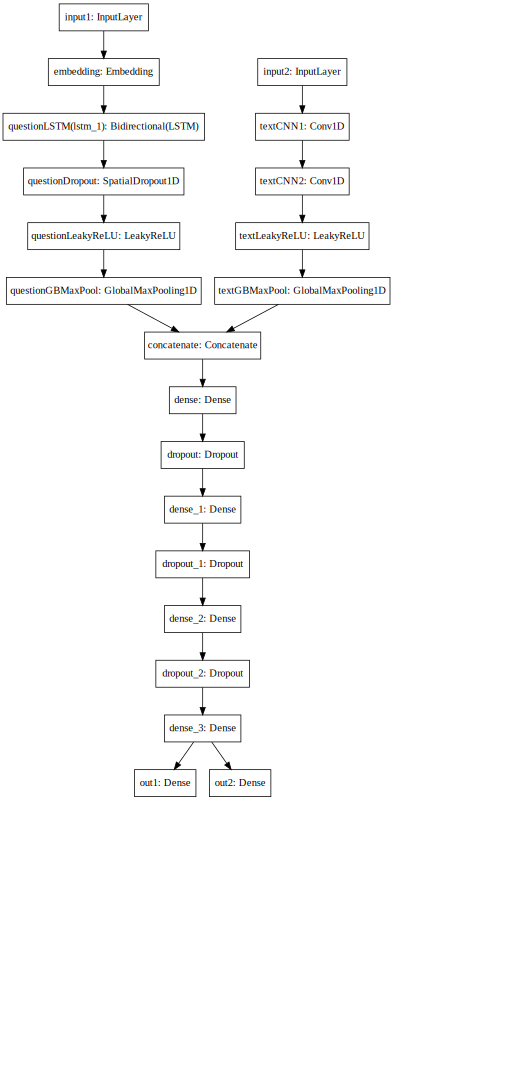

In [ ]:
SVG(model_to_dot(model1).create(prog='dot',format='svg'))

## Image 2

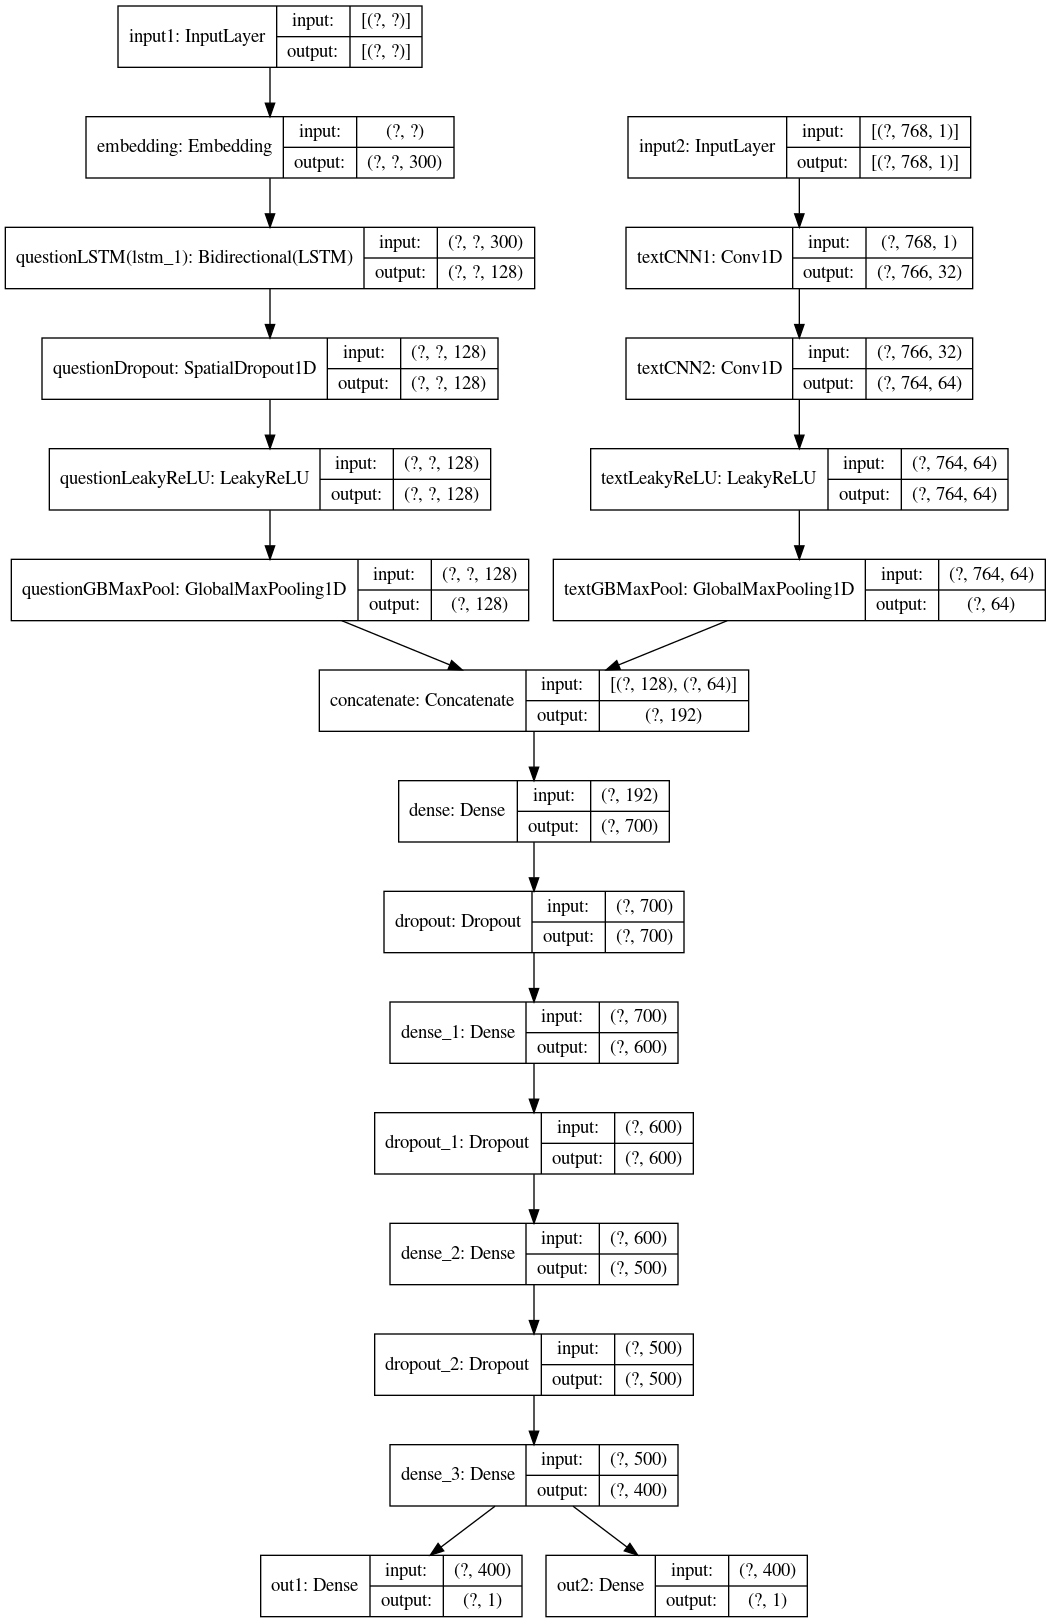

In [ ]:
tf.keras.utils.plot_model(model1,to_file="modellong.png",show_shapes=True)

In [ ]:
y_trainsi=np.array(y_trainl['start_index'])     
#y_cvsi=np.array(y_acv['start_index'])
y_testsi=np.array(y_testl['start_index'])

y_trainei=np.array(y_trainl['end_index'])
#y_cvei=np.array(y_cv['end_index'])
y_testei=np.array(y_testl['end_index'])

In [ ]:
from tensorflow.keras.optimizers import SGD
from swa.tfkeras import SWA

In [ ]:
'''start_epoch=6
swa = SWA(start_epoch=start_epoch, 
          lr_schedule='cyclic', 
          swa_lr=0.001,
          swa_lr2=0.002,
          swa_freq=3,
          verbose=1)
'''

"start_epoch=6\nswa = SWA(start_epoch=start_epoch, \n          lr_schedule='cyclic', \n          swa_lr=0.001,\n          swa_lr2=0.002,\n          swa_freq=3,\n          verbose=1)\n"

In [ ]:
filepath2="longmodel7.cp5"

In [ ]:
checkpoint_4 = ModelCheckpoint(filepath2,mode="max",save_best_only = True,verbose=1)

In [ ]:
logdir1 = os.path.join("logslongfinal", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback3 = TensorBoard(logdir1, histogram_freq=1)
callbacks_4 = [tensorboard_callback3,checkpoint_4]

In [ ]:
tf.profiler.experimental.stop

<function tensorflow.python.profiler.profiler_v2.stop(save=True)>

## Training

In [ ]:
train_history2 = model1.fit({'input1':train_questions,'input2':X_traint1}, 
                           {'out1':y_trainsi,'out2':y_trainei},
    epochs=30,batch_size=534,validation_split=0.35,callbacks=callbacks_4)

Epoch 1/30
97/97 [==============================] - ETA: 0s - loss: 5.0462 - out1_loss: 2.9735 - out2_loss: 2.0727
Epoch 00001: val_loss improved from -inf to 3.45272, saving model to longmodel7.cp5
INFO:tensorflow:Assets written to: longmodel7.cp5/assets
97/97 [==============================] - 71s 733ms/step - loss: 5.0462 - out1_loss: 2.9735 - out2_loss: 2.0727 - val_loss: 3.4527 - val_out1_loss: 2.2018 - val_out2_loss: 1.2509
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 3.4873 - out1_loss: 2.2157 - out2_loss: 1.2716
Epoch 00002: val_loss did not improve from 3.45272
97/97 [==============================] - 45s 461ms/step - loss: 3.4873 - out1_loss: 2.2157 - out2_loss: 1.2716 - val_loss: 3.3465 - val_out1_loss: 2.1425 - val_out2_loss: 1.2040
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 3.4152 - out1_loss: 2.1753 - out2_loss: 1.2399
Epoch 00003: val_loss did not improve from 3.45272
97/97 [==============================] - 45s 463ms/step 

In [ ]:
print(5)



5


In [ ]:
print(5)

5


In [ ]:
model1.save("longmodelfinal")

INFO:tensorflow:Assets written to: longmodelfinal/assets


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logslongfinal --port=6007 --bind_all

## Train vs Validation loss of Start index

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Val_out1_Loss") 
    ax.plot(x, ty, 'r', label="Train Loss")                                       
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    

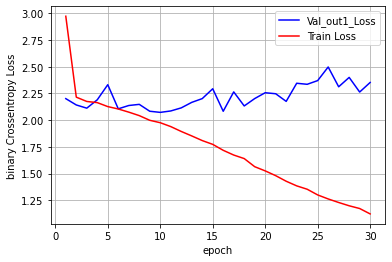

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch nmbers
x = list(range(1,30+1))

vy = train_history2.history['val_out1_loss']
ty = train_history2.history['out1_loss']
plt_dynamic(x, vy, ty, ax)

## Train vs Validation loss of End index

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Val_out2_loss") 
    ax.plot(x, ty, 'r', label="out1_loss")                                       
    plt.legend()
    plt.grid()
    fig.canvas.draw()

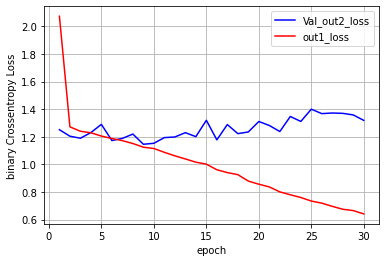

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,30+1))

vy = train_history2.history['val_out2_loss']
ty = train_history2.history['out2_loss']
plt_dynamic(x, vy, ty, ax)

## Prediction of Train data

In [ ]:
#model1=load_model("longmodel7.cp5")

In [ ]:
predtrain1=model1.predict([train_questions,X_traint1])

In [ ]:
trsite=[]
for i in y_trainl['start_index']:
    trsite.append(i)

In [ ]:
treite=[]
for i in y_trainl['end_index']:
    treite.append(i)

In [ ]:
#true start indices
trst=[]
for i in range(len(trsite)):
    c=int(trsite[i])
    trst.append(c)

In [ ]:
#true end indices
tren=[]
for i in range(len(treite)):
    c=int(treite[i])
    tren.append(c)

In [ ]:
#pred start indices
prst=[]
for i in range(len(predtrain1[0])):
    c=int(predtrain1[0][i][0])
    prst.append(c) 
#pred end indices
pren=[]
for i in range(len(predtrain1[0])):
    c=int(predtrain1[1][i][0])
    pren.append(c)

In [ ]:
pr=[]
tr=[]
for i in range(0,len(trst)): #data points count
    tr.append(X_trainl['text'].values[i].split(" ")[trst[i]:tren[i]]) #true start and end indices
    pr.append(X_trainl['text'].values[i].split(" ")[prst[i]:pren[i]])# pred start and end indices

In [ ]:
def Avg(lst): 
    return sum(lst) / len(lst) 

## Jaccard Similarity of Train data

In [ ]:
def jaccard_similarity(tr,pr): #true values and pred values 
#intersection
    jk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i]) 
        c= len(set(a).intersection(b))
        jk.append(c) 
#union
    vk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i])
        v= len(list(a.union(b)))
        vk.append(v)
        
#intersection/union        
    f=[]
    for i in range(len(jk)):
        jac=jk[i]/vk[i]
        f.append(jac)
        
    return Avg(f)
    
    
print("The Jaccard Similarity for long answer model is:",jaccard_similarity(tr,pr))

The Jaccard Similarity for long answer model is: 0.26233908629976177


In [ ]:
predtrain1[0]

array([[ 269.45688],
       [1058.3607 ],
       [ 534.7253 ],
       ...,
       [1041.4795 ],
       [ 275.20837],
       [1826.2657 ]], dtype=float32)

## Test data Prediction

In [ ]:
X_testt1=X_test_pooled_output1.reshape(X_test_pooled_output1.shape[0],X_test_pooled_output1.shape[1],1) 

In [ ]:
predf1=model1.predict([test_questions,X_testt1])    

In [ ]:
predf1[0]

array([[ 55.807426],
       [ 70.26933 ],
       [582.9036  ],
       ...,
       [ 72.333046],
       [142.46422 ],
       [178.9608  ]], dtype=float32)

In [ ]:
predf1[1]

array([[180.66989],
       [220.403  ],
       [999.3216 ],
       ...,
       [226.58205],
       [339.16895],
       [374.03317]], dtype=float32)

In [ ]:
trsite=[]
for i in y_testl['start_index']:
    trsite.append(i)
treite=[]
for i in y_testl['end_index']:
    treite.append(i)
#true start indices
trst=[]
for i in range(len(trsite)):
    c=int(trsite[i])
    trst.append(c)
#true end indices
tren=[]
for i in range(len(treite)):
    c=int(treite[i])
    tren.append(c)

In [ ]:
#pred start indices
prst=[]
for i in range(len(predf1[0])):
    c=int(predf1[0][i][0])
    prst.append(c) 
#pred end indices
pren=[]
for i in range(len(predf1[0])):
    c=int(predf1[1][i][0])
    pren.append(c)

In [ ]:
pr=[]
tr=[]
for i in range(0,len(trst)): #data points count
    tr.append(X_testl['text'].values[i].split(" ")[trst[i]:tren[i]]) #true start and end indices
    pr.append(X_testl['text'].values[i].split(" ")[prst[i]:pren[i]])# pred start and end indices

In [ ]:
def Avg(lst): 
    return sum(lst) / len(lst) 

## Jaccard Similarity of test data

In [ ]:
def jaccard_similarity(tr,pr): #true values and pred values 
#intersection
    jk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i]) 
        c= len(set(a).intersection(b))
        jk.append(c) 
#union
    vk=[]
    for i in range(len(trst)):
        a = set(tr[i])
        b = set(pr[i])
        v= len(list(a.union(b)))
        vk.append(v)
        
#intersection/union        
    f=[]
    for i in range(len(jk)):
        jac=jk[i]/vk[i]
        f.append(jac)
        
    return Avg(f)
    
    
print("The Jaccard Similarity for long answer model is:",jaccard_similarity(tr,pr))

The Jaccard Similarity for long answer model is: 0.22452200114734572
